In [1]:
!which python

/home/paperspace/anaconda3/envs/fastai/bin/python


In [30]:
import enum
import time

import torch
from torch import nn, optim
from torch.utils.data import DataLoader

from ssdmultibox.criterion import SSDLoss
from ssdmultibox.datasets import PascalDataset, TrainPascalFlatDataset, device
from ssdmultibox.models import SSDModel

import matplotlib.pyplot as plt
plt.ion()

In [3]:
device

device(type='cuda', index=0)

In [44]:
losses = {'total':[], 'loc':[], 'conf':[]}

In [39]:
model = SSDModel().to(device)

In [40]:
LR = 0.01

criterion = SSDLoss(alpha=100)
optimizer = optim.SGD(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
current_time = time.time()

In [41]:
BATCH = 32
NUM_WORKERS = 8 # MAC: sysctl -n hw.ncpu or LINUX: nproc --all

train_dataset = TrainPascalFlatDataset()
dataloader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True, num_workers=NUM_WORKERS)

In [54]:
EPOCHS = 4

for epoch in range(EPOCHS):
    scheduler.step()

    for i, (image_ids, ims, gt_bbs, gt_cats) in enumerate(dataloader):
        # put data on device
        ims, gt_bbs, gt_cats = PascalDataset.to_device(ims, gt_bbs, gt_cats)

        # zero out gradients
        optimizer.zero_grad()

        # forward pass
        with torch.set_grad_enabled(True):
            preds = model(ims)
            loss, loc_loss, conf_loss = criterion(preds, (gt_bbs, gt_cats))

            # backward pass
            loss.backward()
            optimizer.step()

        # stats
        if i % 5 == 0:
            print(i, 'loss:', loss.item(), 'time:', time.time() - current_time)
            current_time = time.time()
            losses['total'].append(loss.item())
            losses['loc'].append(loc_loss.item())
            losses['conf'].append(conf_loss.item())

bbs_loss: 4.3757405281066895
cats_loss: 697.007080078125
0 loss: 4.767148017883301 time: 196.50068354606628
bbs_loss: 2.8132896423339844
cats_loss: 689.7011108398438
bbs_loss: 2.7240347862243652
cats_loss: 976.9451904296875
bbs_loss: 2.956130266189575
cats_loss: 696.7368774414062
bbs_loss: 2.750243663787842
cats_loss: 690.6109619140625
bbs_loss: 2.770062208175659
cats_loss: 779.8198852539062
5 loss: 3.988023281097412 time: 6.889602899551392
bbs_loss: 2.5151302814483643
cats_loss: 780.7255859375
bbs_loss: 1.6619436740875244
cats_loss: 486.6298522949219
bbs_loss: 2.7252449989318848
cats_loss: 611.763427734375
bbs_loss: 3.057448387145996
cats_loss: 767.5308837890625
bbs_loss: 2.475585460662842
cats_loss: 787.844970703125
10 loss: 3.863445997238159 time: 6.928077936172485
bbs_loss: 2.2538564205169678
cats_loss: 875.37060546875
bbs_loss: 3.427579879760742
cats_loss: 871.4742431640625
bbs_loss: 3.4463329315185547
cats_loss: 832.62646484375
bbs_loss: 3.34958815574646
cats_loss: 853.8518676757

bbs_loss: 2.250917673110962
cats_loss: 609.7182006835938
bbs_loss: 2.010385751724243
cats_loss: 577.8256225585938
bbs_loss: 2.5520389080047607
cats_loss: 788.50146484375
45 loss: 3.909008741378784 time: 6.929301977157593
bbs_loss: 3.1045963764190674
cats_loss: 687.2202758789062
bbs_loss: 2.063093423843384
cats_loss: 700.9754028320312
bbs_loss: 2.3868839740753174
cats_loss: 732.2330932617188
bbs_loss: 3.1741440296173096
cats_loss: 687.4566650390625
bbs_loss: 2.9816036224365234
cats_loss: 622.0299072265625
50 loss: 4.402824401855469 time: 6.925104856491089
bbs_loss: 3.2490546703338623
cats_loss: 773.023193359375
bbs_loss: 2.2864108085632324
cats_loss: 678.9700317382812
bbs_loss: 3.0930464267730713
cats_loss: 727.0598754882812
bbs_loss: 2.146305561065674
cats_loss: 550.6859741210938
bbs_loss: 2.8275306224823
cats_loss: 719.8173828125
55 loss: 4.1088948249816895 time: 6.929620981216431
bbs_loss: 3.2170896530151367
cats_loss: 930.2462768554688
bbs_loss: 1.4428857564926147
cats_loss: 672.962

bbs_loss: 3.393399715423584
cats_loss: 681.1292114257812
bbs_loss: 1.9366648197174072
cats_loss: 400.59344482421875
bbs_loss: 2.2202978134155273
cats_loss: 608.0789794921875
bbs_loss: 2.512619972229004
cats_loss: 627.0087280273438
bbs_loss: 3.547741413116455
cats_loss: 825.156494140625
10 loss: 4.199041366577148 time: 6.927156925201416
bbs_loss: 2.377446174621582
cats_loss: 542.0442504882812
bbs_loss: 3.255115270614624
cats_loss: 743.4267578125
bbs_loss: 2.8350331783294678
cats_loss: 735.3587036132812
bbs_loss: 3.1039438247680664
cats_loss: 835.314697265625
bbs_loss: 1.9680891036987305
cats_loss: 655.6373291015625
15 loss: 3.839848041534424 time: 6.931428670883179
bbs_loss: 3.237997531890869
cats_loss: 775.8395385742188
bbs_loss: 2.400108575820923
cats_loss: 642.7236328125
bbs_loss: 3.146904706954956
cats_loss: 866.287109375
bbs_loss: 2.3794243335723877
cats_loss: 727.0926513671875
bbs_loss: 3.8957760334014893
cats_loss: 849.2194213867188
20 loss: 4.286494731903076 time: 6.933467388153

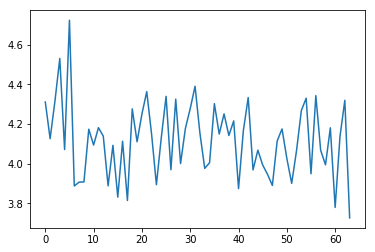

In [51]:
plt.plot(losses['total'])

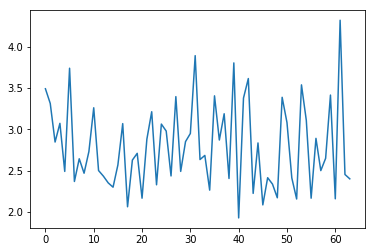

In [52]:
plt.plot(losses['loc'])

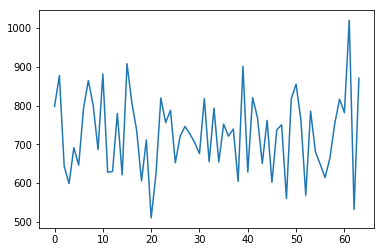

In [53]:
plt.plot(losses['conf'])

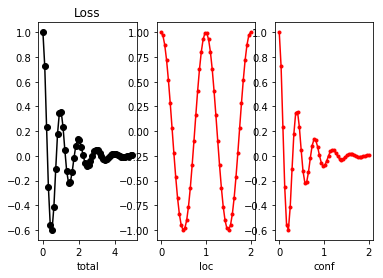

In [36]:
import numpy as np
import matplotlib.pyplot as plt


x1 = np.linspace(0.0, 5.0)
x2 = np.linspace(0.0, 2.0)

y1 = np.cos(2 * np.pi * x1) * np.exp(-x1)
y2 = np.cos(2 * np.pi * x2)

plt.subplot(1, 3, 1)
plt.plot(x1, y1, 'ko-')
plt.title('Loss')
plt.xlabel('total')

plt.subplot(1, 3, 2)
plt.plot(x2, y2, 'r.-')
plt.xlabel('loc')

plt.subplot(1, 3, 3)
plt.plot(x2, y1, 'r.-')
plt.xlabel('conf')


plt.show()

In [ ]:
plt.subplot()